<a href="https://colab.research.google.com/github/flokoafon/WQU_project/blob/WQU/WQU_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import io
import datetime
import statsmodels.api as sm
from google.colab import files

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
url = "https://raw.githubusercontent.com/flokoafon/WQU_project/main/ProjectData.xlsx"
series = pd.read_excel(url)
series.head()

,Date,DPI,IPI,COP,SIR,LTIR,NGP
0,2000-01-01,6835.600098,76.49362,27.01,3.09,5.539524,NaN
1,2000-02-01,7644.549805,78.39347,29.30,3.14,5.508571,NaN
2,2000-03-01,7599.390137,78.49346,29.89,3.36,5.333043,NaN
3,2000-04-01,7414.680176,79.49338,25.54,3.53,5.225556,NaN
4,2000-05-01,7109.669922,81.39322,28.81,3.87,5.378182,NaN


As you'll see it in the report, the abreviations used above have the following meanings:
DPI: Dax Performance Index
IPI: Industrial Production Index
COP: Crude Oil Price
SIR: Short term Interest Rate
LTIR: Long-Term Interest Rate
NGP: Natural Gas Price

In [4]:
#Defining date column as index
#series['Date'] = pd.to_datetime(series['Date'], dayfirst = True)
series.set_index('Date', inplace = True)
series

,DPI,IPI,COP,SIR,LTIR,NGP
Date,,,,,,
2000-01-01,6835.600098,76.49362,27.01,3.09,5.539524,NaN
2000-02-01,7644.549805,78.39347,29.30,3.14,5.508571,NaN
2000-03-01,7599.390137,78.49346,29.89,3.36,5.333043,NaN
2000-04-01,7414.680176,79.49338,25.54,3.53,5.225556,NaN
2000-05-01,7109.669922,81.39322,28.81,3.87,5.378182,NaN
...,...,...,...,...,...,...
2021-11-01,15100.129883,94.29214,79.18,-0.52,-0.313636,NaN
2021-12-01,15884.860352,95.79202,71.69,-0.58,-0.384286,NaN
2022-01-01,15471.200195,96.39197,82.98,-0.50,-0.114762,NaN


In [5]:
#Select date where all series are available
#This because npg serie is only available between 01/01/2007 and 01/06/2021
intermediate = series.reset_index()
first = intermediate.loc[intermediate['Date']=='2007-01-01']
last = intermediate.loc[intermediate['Date']=='2021-06-01']
begin = first.index[0]
end = last.index[0]
complete_series = intermediate.loc[begin:end,]

In [6]:
#Complete_series is the dateframe containing all the rows of series with available data
complete_series

,Date,DPI,IPI,COP,SIR,LTIR,NGP
84,2007-01-01,6789.109863,95.09208,54.35,3.48,4.016818,2.4168
85,2007-02-01,6715.439941,95.49204,59.39,3.50,4.049000,2.4168
86,2007-03-01,6917.029785,95.99200,60.74,3.67,3.940909,2.4168
87,2007-04-01,7408.870117,95.09208,64.04,3.72,4.152105,2.4168
88,2007-05-01,7883.040039,96.79193,63.53,3.76,4.279048,2.4168
...,...,...,...,...,...,...,...
253,2021-02-01,13786.290039,95.19207,59.06,-0.26,-0.445500,2.0592
254,2021-03-01,15008.339844,95.89201,62.36,-0.12,-0.364783,2.0592
255,2021-04-01,15135.910156,95.69202,61.70,-0.25,-0.325000,2.0592
256,2021-05-01,15421.129883,95.19207,65.16,-0.34,-0.223500,2.0592


In the following cells, we plot the different series in order to have first apppreciations of their behaviors

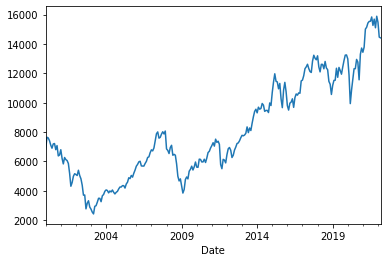

In [7]:
#First vizualisation of data
DPI = series['DPI']
DPI.plot()

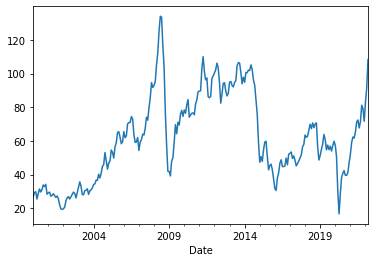

In [8]:
COP =series['COP']
COP.plot()

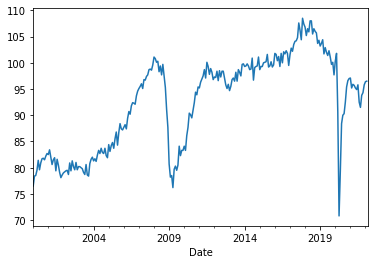

In [9]:
IPI = series['IPI']
IPI.plot()

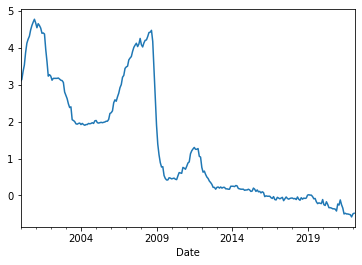

In [10]:
SIR = series['SIR']
SIR.plot()

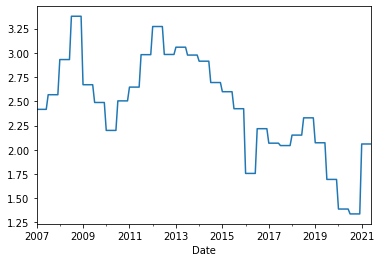

In [11]:
complete_series.set_index('Date', inplace = True)
NGP = complete_series['NGP']
NGP.plot()

In [12]:
# Compute some descriptive statistics
series.describe()

,DPI,IPI,COP,SIR,LTIR,NGP
count,267.000000,266.000000,267.000000,266.000000,267.000000,174.000000
mean,8100.129177,92.554318,61.425094,1.379850,2.304052,2.441931
std,3385.521911,8.941259,25.681007,1.610145,1.905739,0.514635
min,2423.870117,70.794100,16.700000,-0.580000,-0.649091,1.337200
25%,5603.625000,82.943088,40.970000,-0.017500,0.347702,2.071700
50%,7158.770020,95.592030,59.060000,0.615000,2.615909,2.487600
75%,11059.034668,99.391720,80.425000,2.657500,4.022273,2.914000
max,15884.860352,108.491000,134.020000,4.770000,5.539524,3.378000


In the followings we study seasonnality of each series by 

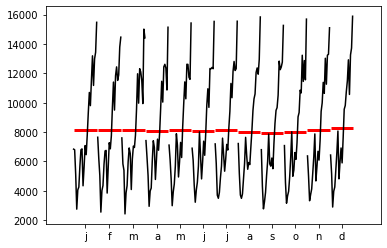

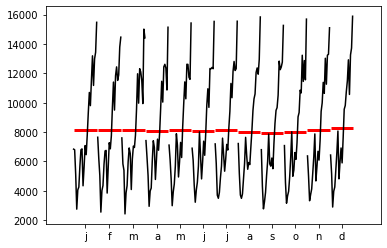

In [15]:
#Monthplot for DPI
sm.graphics.tsa.month_plot(DPI)

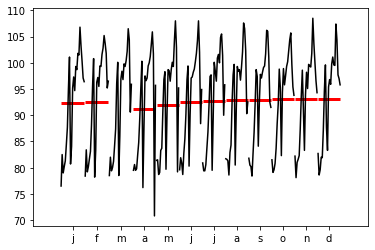

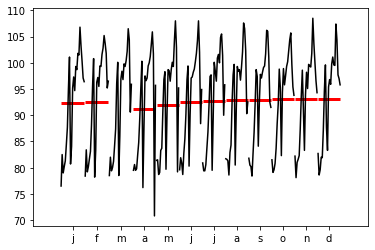

In [16]:
#Monthplot for IPI
sm.graphics.tsa.month_plot(IPI)

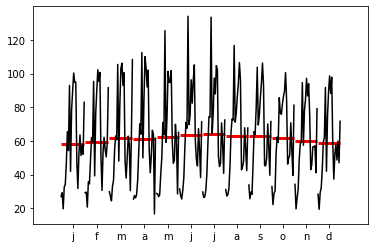

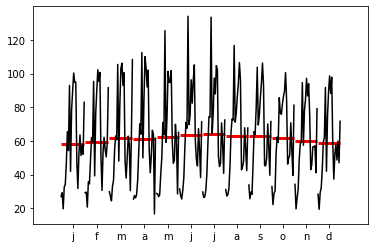

In [17]:
#Monthplot for COP
sm.graphics.tsa.month_plot(COP)

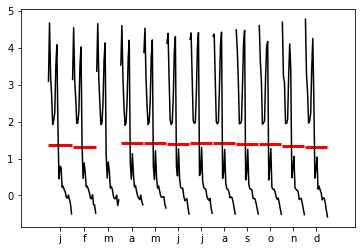

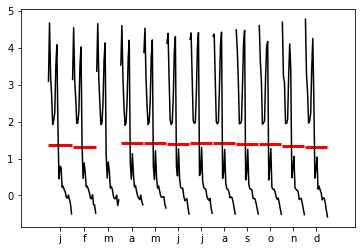

In [18]:
#Monthplot for SIR
sm.graphics.tsa.month_plot(SIR)

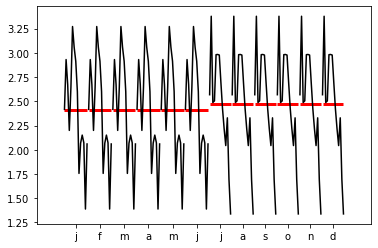

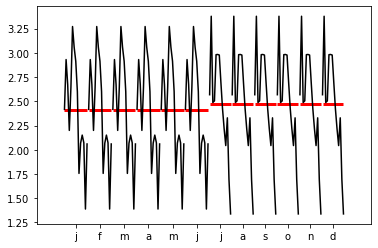

In [19]:
#Monthplot for NGP
sm.graphics.tsa.month_plot(NGP)